# Рекомендация тарифов

**Описание проекта**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

**Цель исследования**

Нужно построить модель для задачи классификации с максимально большим значением *accuracy*, которая выберет подходящий тариф.  Доля правильных ответов должна быть не менее 0.75.

**Ход исследования**

- Исследовательский анализ
- Формирование выборок
- Исследование моделей:
    - DecisionTree
    - RandomForest
    - LogisticRegression
- Проверка лучшей модели на тестовой выборке
- Проверка лучшей модели на адекватность

## Исследовательский анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

Импортируем данные в переменную "data" и посмотрим общий вид таблицы. 

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Сравним показатели для пользователей тарифов "Смарт" и "Ультра".

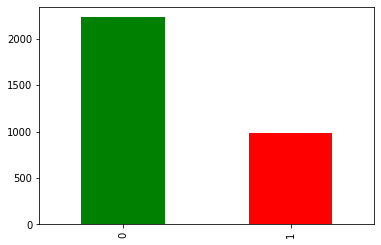

In [3]:
data['is_ultra'].value_counts().plot(kind='bar', x='is_ultra', color=['green', 'red']);

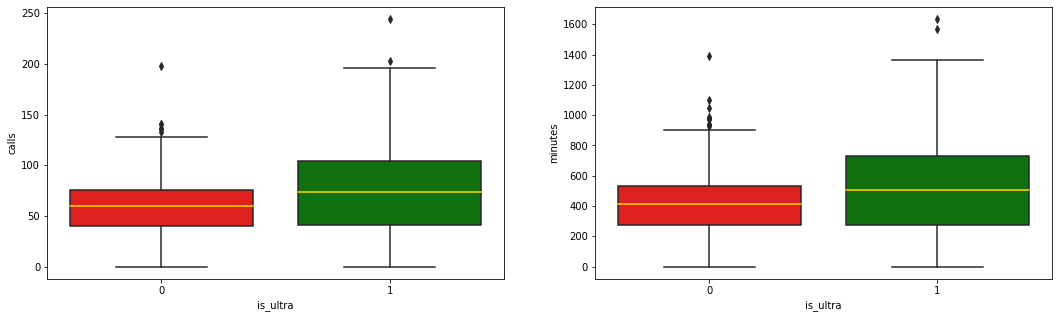

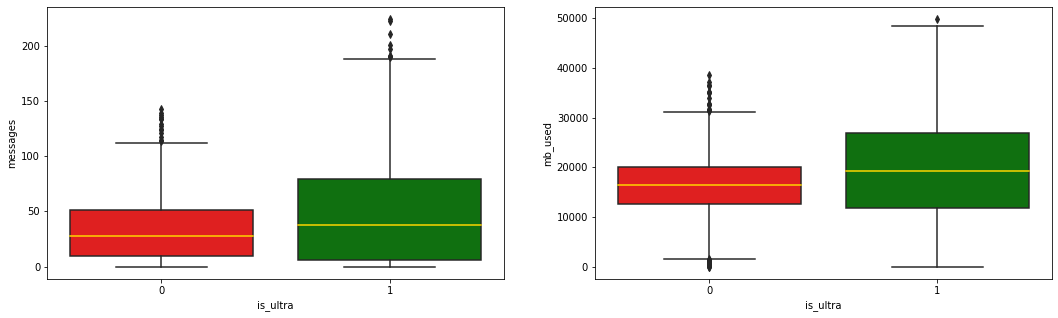

In [4]:
christmas = {"g","r"} #палитра цветов

fig, axis = plt.subplots(1,2 , figsize=(18,5))                                      
          
sns.boxplot(x='is_ultra', y='calls',   data=data, ax=axis[0], palette = christmas, medianprops={"color": "gold"});
sns.boxplot(x='is_ultra', y='minutes', data=data, ax=axis[1], palette = christmas, medianprops={"color": "gold"});

fig, axis = plt.subplots(1,2 , figsize=(18,5))

sns.boxplot(x='is_ultra', y='messages', data=data, ax=axis[0], palette = christmas, medianprops={"color": "gold"});
sns.boxplot(x='is_ultra', y='mb_used', data=data, ax=axis[1], palette = christmas, medianprops={"color": "gold"});

*ВЫВОД: данные представлены пользователями тарифов "Смарт" - 70%, "Ультра" - 30%. Пользователи тарифа "Ультра" имеют бОльший диапозон по всем показателям, а также медианное значение т.е. используют больше звонков, минут, сообщений и интернета.*

Посмотрим корреляцию между опциями тарифа (признаками) и тарифом (целевой признак).

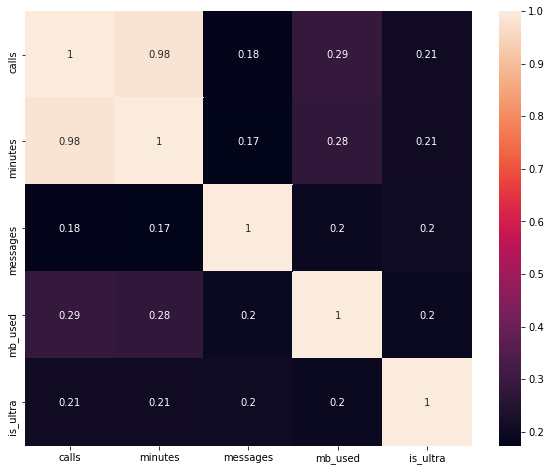

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True);

*ВЫВОД: никаких выраженных взаимосвязей не обнаружено*

## Формирование выборок

Выделим признаки и целевой признак. Разобъем данные на обучающую - 60%, валидационную - 20% и тестовую - 20% - выборки.

Разбиение производиться в два этапа:

- первый раз данные разбиваем на обучающую выборку - 70% и валидационную + тестовую - 30%
- далее разбиваем валидационную + тестовую на валидационную - 15% и тестовую - 15% выборки.

In [6]:
features = data.drop('is_ultra', axis=1) #признаки
target = data['is_ultra'] # целевой признак

In [7]:
features_train, features_test_val, target_train, target_test_val = train_test_split(
    features, target, train_size=0.7, random_state=12345)


features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_val,target_test_val,train_size=0.5,random_state=12345)


## Исследование моделей

Исследуем следующие модели:

- DecisionTree
- RandomForest
- LogisticRegression

Для каждой модели выявим оптимальные параметры.

### DecisionTree

Для данной модели подберем 3 параметра:

- max_depth
- min_samples_split
- min_samples_leaf

In [ ]:
for depth in range(1,6):
    
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    
    predictions_valid = model_dtc.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid).round(2)
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_valid)  

In [ ]:
for samples_split in range(2,20):
    
    model_s = DecisionTreeClassifier(random_state=12345, min_samples_split=samples_split)
    model_s.fit(features_train, target_train)
    
    predictions_valid = model_s.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid).round(2)
    
    print("min_samples_split =", samples_split, ": ", end='')
    print(accuracy_valid)

In [ ]:
best_model = None
best_result = 0

for samples_leaf in range(1,15):
    
    model_l = DecisionTreeClassifier(random_state=12345, min_samples_leaf=samples_leaf)
    model_l.fit(features_train, target_train)
    
    predictions_valid = model_l.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid).round(2)

    print(" min_samples_leaf =", samples_leaf, ": ", end='')
    print(accuracy_valid)

*ВЫВОД: лучшая модель decision tree имеет параметр max_depth = 3, accuracy = 0.79 на валидационной выбоке*



### RandomForest

In [ ]:
for est in range(1, 11):
    
    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_rfc.fit(features_train, target_train)
    
    predictions_valid = model_rfc.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid).round(3)
    
    print("n_estimators =", est, ": ", end='')
    print(accuracy_valid) 

*ВЫВОД: лучшая модель random forest имеет параметр n_estimators = 10, accuracy = 0.77 на валидационной выбоке*



### LogisticRegression

In [ ]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 

model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)

accuracy_valid = accuracy_score(target_valid, predictions).round(3)
accuracy_valid

*ВЫВОД: модель logistic regression имеет accuracy = 0.70 на валидационной выбоке*



**ВЫВОД**

Лучшая из трех моделей - ***decision tree с параметром max_depth = 3***, которая имеет наибольшую ***accuracy = 0.79***. Ее и будем проверять на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3)

model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

accuracy_test = accuracy_score(target_test, predictions_test).round(2)
accuracy_test

*ВЫВОД: модель справилась на тестовом множестве с accuracy = 0.79*

## Проверка модели на адекватность

Проверим насколько лучше работает наша модель по сравнению с *DummyClassifier - классификатор, который делает прогнозы,используя простые правила.*

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(features_train, target_train)
predictions_dummy = dummy.predict(features_test)

accuracy_dummy = accuracy_score(target_test, predictions_dummy).round(3)
accuracy_dummy

*ВЫВОД: наша модель адекватна, работает лучше DummyClassifier.*

## ВЫВОД

- Исследовательский анализ показал, что данные представлены пользователями тарифов "Смарт" - 70%, "Ультра" - 30%. Пользователи тарифа "Ультра" используют больше звонков, минут, сообщений и интернета. Также никаких выраженных взаимосвязей между тарифами и опциями не было обнаружено.
- Исследование моделей показало, что ***лучшая модель - decision tree с параметром max_depth = 3 с accuracy = 0.79 на валидационной выборке.***
- Лучшая модель успешно прошла ***проверку на тестовом множестве с accuracy = 0.79.***
- Лучшая модель выдержала проверку на адекватность

## Автоматический подбор параметров 

Ради интереса выполним подборку гиперпараметров моделей с помощью модуля GridSearchCV и сравним с уже имеющимися результатами.

In [ ]:
f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.25, random_state = 0, stratify=target)

In [ ]:
#автоматический подбор параметров для DecisionTreeClassifier

parameters = {'max_depth' : range(1,10), 'min_samples_leaf' : range(1,20,5), 'min_samples_split' : range(2,20,5)}

model_1 = DecisionTreeClassifier(random_state=12345)
grid_1 = GridSearchCV(model_1, parameters, cv=5, verbose=1)
grid_1.fit(f_train, t_train)
best_model_1 = grid_1.best_params_
best_model_1

In [ ]:
model_1_1 = DecisionTreeClassifier(random_state=12345, max_depth=3, min_samples_leaf=1, min_samples_split=2)
model_1_1.fit(features_train, target_train)
predictions_1_1 = model_1_1.predict(features_test)

accuracy_1_1 = accuracy_score(target_test, predictions_test)
accuracy_1_1

In [ ]:
#автоматический подбор параметров для RandomForestClassifier

parameters = {'max_depth' : range(1,20,2), 'min_samples_leaf' : range(1,20,5), 'n_estimators' : range(1,20,2)}

model_2 = RandomForestClassifier(random_state=12345)
grid_2 = GridSearchCV(model_2, parameters, cv=5, verbose=1)
grid_2.fit(f_train, t_train)
best_model_2 = grid_2.best_params_
best_model_2

In [ ]:
model_2_1 = RandomForestClassifier(random_state=12345, max_depth=13, min_samples_leaf=11, n_estimators=19)
model_2_1.fit(f_train, t_train)
predictions = model_2_1.predict(f_test)

accuracy_2_1 = accuracy_score(t_test, predictions)
accuracy_2_1

In [ ]:
# модель LogisticRegression на стратифицированных выборках

model_3 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 

model_3.fit(f_train, t_train)
predictions = model_3.predict(f_test)

accuracy_3 = accuracy_score(t_test, predictions)
accuracy_3

**ВЫВОД:**  
При автоматическом подборе параметром с помощью модуля GridSearchCV получаем другой результат.  
***Лучшая модель - RandomForestClassifier; accuracy на тестовой выборке - 0.8.***   
Также при разбивке необходимо стратифицировать данные т.к. мы выяснили, что количество пользователей тарифов распределено неравномерно.